## Import

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

import string
import re

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\NS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Global Variables/Objects

In [2]:
DATASET_FILENAME      = 'SMSSpamCollection'
ENCODING              = 'utf-8'
STOPWORDS             = set(stopwords.words('english'))
PORTERSTEMMER         = nltk.PorterStemmer()
ALL_WORDS             = list()
FEATURES              = list()
LABEL_ENCODER         = LabelEncoder()
WORDNET_LEMMATIZER    = WordNetLemmatizer()

# Regular expression patterns
# Sources:
# https://stackoverflow.com/questions/201323/how-to-validate-an-email-address-using-a-regular-expression
# https://www.regextester.com/
# https://regexr.com/
# https://remarkablemark.org/blog/2019/09/28/javascript-remove-punctuation/
# https://www.i2tutorials.com/match-urls-using-regular-expressions-in-python/

EMAIL_REGEX            = '(?:[a-z0-9!#$%&\'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&\'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])'
WEBURL_REGEX           = '(http|ftp|https):\/\/([\w\-_]+(?:(?:\.[\w\-_]+)+))([\w\-\.,@?^=%&:/~\+#]*[\w\-\@?^=%&/~\+#])?'
CURRENCY_REGEX         = '£|\$|€'
PHONE_REGEX            = '^[+]*[(]{0,1}[0-9]{1,4}[)]{0,1}[-\s\./0-9]*$'
NUMBER_REGEX           = '\d+(\.\d+)?'
PUNCTUATION_REGEX      = f'[{string.punctuation}]+'
EXTRA_WHITESPACE_REGEX = '\s+'
ENDS_WHITESPACE_REGEX  = '^\s+|\s+$'

## Load dataset

In [3]:
# Load sms spam collection dataset

sms_messages_df = pd.read_table(DATASET_FILENAME,
                                header=None,
                                encoding=ENCODING)

In [4]:
sms_messages_df.info()

# So we can see we have two columns in the dataset
# Both the columns have data as object type
# Column 0 is class label, column 1 is sms text
# class label can take two values: spam, ham
# ham = not spam i.e. genuine message

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5572 non-null   object
 1   1       5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
sms_messages_df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Checking class label distribution

sms_messages_df.iloc[:, 0].value_counts()
# The dataset is unbalanced

ham     4825
spam     747
Name: 0, dtype: int64

In [7]:
# Preparing separating feature and response variables

# feature variable: sms text
sms_text = sms_messages_df.iloc[:, 1]

# response variable: class label (categorical)
# encoding the class labels using label encoder 
sms_label = LABEL_ENCODER.fit_transform(sms_messages_df.iloc[:, 0].values)

## Preprocessing

In [8]:
def preprocess(text):
    """
    Function to perform basic preprocessing on the text.
    """
    
    global EMAIL_REGEX
    global WEB_URL
    global CURRENVY_REGEX
    global PHONE_REGEX
    global NUMBER_REGEX
    global PUNCTUATION_REGEX
    global EXTRA_WHITESPACE_REGEX
    global ENDS_WHITESPACE_REGEX
    global STOPWORDS
    
    text = re.sub(rf'{EMAIL_REGEX}', 'emailid', text)
    text = re.sub(rf'{WEBURL_REGEX}', 'weburl', text)
    text = re.sub(rf'{CURRENCY_REGEX}', 'currencysymbol', text)
    text = re.sub(rf'{PHONE_REGEX}', 'phonenumber', text)
    text = re.sub(rf'{NUMBER_REGEX}', 'number', text)
    text = re.sub(rf'{PUNCTUATION_REGEX}', ' ', text)
    text = re.sub(rf'{EXTRA_WHITESPACE_REGEX}', ' ', text)
    text = re.sub(rf'{ENDS_WHITESPACE_REGEX}', '', text)
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    text = ' '.join(WORDNET_LEMMATIZER.lemmatize(word) for word in text.split())
    
    return text

In [9]:
# Apply preprocessing

preprocessed_sms_text = sms_text.apply(preprocess)

In [10]:
# vectorize feature variable: sms text

vectorizer = CountVectorizer()
vectorizer.fit(preprocessed_sms_text.values)

vectorized_sms_text = vectorizer.transform(preprocessed_sms_text.values)

In [11]:
# prepare data for training:
# train_X  : training instance of sms text
# test_X   : testing instance of sms text
# train_y  : training instance of label
# test_y   : testing instance of label

train_X, test_X, train_y, test_y = train_test_split(vectorized_sms_text,
                                                    sms_label,
                                                    test_size=0.10,
                                                    stratify=sms_label)

## Classification

In [12]:
def classifiers():
    
    return [
        ('KNeighborsClassifier', KNeighborsClassifier()),
        ('DecisionTreeClassifier', DecisionTreeClassifier()),
        ('RandomForestClassifier', RandomForestClassifier()),
        ('LogisticRegression', LogisticRegression()),
        ('SGDClassifier', SGDClassifier()),
        ('MultinomialNB', MultinomialNB()),
        ('SVC', SVC())
    ]

In [13]:
# Training and testing data on different classifiers

for clf_name, clf in classifiers():
    # currently not updating any default parameters
    clf.fit(train_X, train_y)
    predictions_y = clf.predict(test_X)
    accuracy = accuracy_score(test_y, predictions_y)
    print(f'{clf_name} Accuracy (%): {accuracy:10}')

KNeighborsClassifier Accuracy (%): 0.953405017921147
DecisionTreeClassifier Accuracy (%): 0.9838709677419355
RandomForestClassifier Accuracy (%): 0.989247311827957
LogisticRegression Accuracy (%): 0.989247311827957
SGDClassifier Accuracy (%): 0.9874551971326165
MultinomialNB Accuracy (%): 0.974910394265233
SVC Accuracy (%): 0.9838709677419355


In [14]:
# Training and testing data on ensemble of classifiers

estimators = classifiers()
clf = VotingClassifier(estimators = estimators, n_jobs=-1)
clf.fit(train_X, train_y)
predictions_y = clf.predict(test_X)
accuracy = accuracy_score(test_y, predictions_y) 
print(f'Voting Classifier Accuracy: {accuracy:10}')

Voting Classifier Accuracy: 0.9874551971326165


In [15]:
confusion_matrix(test_y, predictions_y)

array([[483,   0],
       [  7,  68]], dtype=int64)

In [16]:
roc_auc_score(test_y, predictions_y)

0.9533333333333334

In [17]:
fpr, tpr, threshold = roc_curve(test_y, predictions_y)

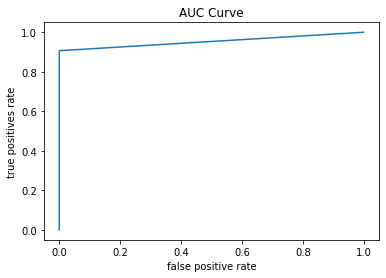

In [18]:
plt.plot(fpr, tpr)
plt.title('AUC Curve')
plt.xlabel('false positive rate')
plt.ylabel('true positives rate')
plt.show()